In [2]:
#载入包
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import os#在服务器运行，习惯性会设置一个输出路径，用于保存pdf图片

In [3]:
sc.settings.verbosity = 3 # verbosity 的取值表示测试结果显示的详细程度，数字越大越详细
sc.logging.print_versions() # 输出版本号
sc.settings.set_figure_params(dpi=80) # set_figure_params 设置图片的分辨率/大小以及其他样式

-----
anndata     0.10.9
scanpy      1.10.4
-----
PIL                         11.0.0
anyio                       NA
argcomplete                 NA
asttokens                   NA
attr                        24.2.0
attrs                       24.2.0
babel                       2.11.0
brotli                      1.0.9
certifi                     2024.08.30
charset_normalizer          3.3.2
comm                        0.2.1
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
h5py                        3.12.1
idna                        3.7
igraph                      0.11.2
ipykernel                   6.29.5
jaraco                      NA
jedi                        0.19.1
jinja2                      3.1.4
joblib                      1.4.2
json5                       NA
j

In [29]:
os.getcwd()  #查看当前路径
os.chdir('/home/bioinfo2/PB22081501/07_scanpyresult/bioclass/') #修改路径
os.getcwd()
results_file = 'output' ##置结果文件保存路径

In [177]:
data=sc.read_10x_mtx('/home/bioinfo2/PB22081501/bioclass/scRNA-seq/data',var_names='gene_symbols',   cache=True)
data.var_names_make_unique()  # 索引去重，若上一步中使用 `var_names='gene_ids'` 则这一步非必须进行
#data.X 存储 count matrix，数据类型为稀疏矩阵 scipy.sparse.csr.csr_matrix
#data.obs 存储关于 obervations(cells) 的 metadata，数据类型为 dataframe
#data.var 存储关于 variables(genes) 的 metadata，数据类型为 dataframe
#AnnData.uns 存储后续附加的其他非结构化信息
#data.obs_names 和 adata.var_names index
#细胞名和基因名可分别通过 adata.obs_names 和 adata.var_names 查看。 AnnData 对象可以像 dataframe

... reading from cache file cache/home-bioinfo2-PB22081501-bioclass-scRNA-seq-data-matrix.h5ad


normalizing counts per cell
    finished (0:00:00)


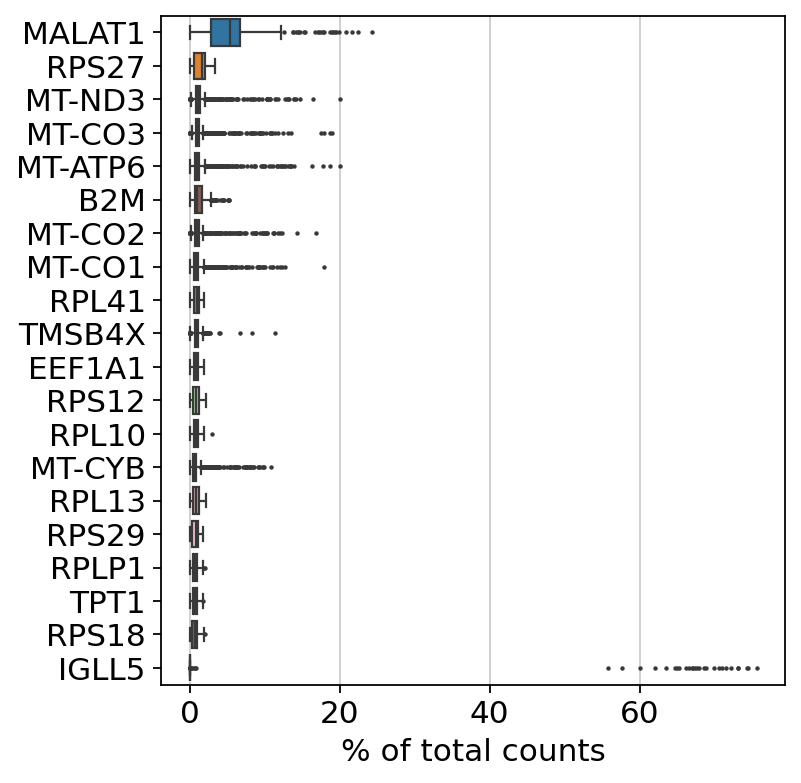

In [66]:
sc.pl.highest_expr_genes(data, n_top=20)

In [178]:
#基础过滤：去除表达基因200以下的细胞；去除在3个细胞以下表达的基因。
sc.pp.filter_cells(data, min_genes=100)
sc.pp.filter_genes(data, min_cells=3)

filtered out 26 cells that have less than 100 genes expressed
filtered out 16430 genes that are detected in less than 3 cells


In [179]:
# annotate the group of mitochondrial genes as "mt"# 将线粒体基因组注释为 "mt”然后利用下面的函数计算线粒体基因的质量
data.var["mt"] = data.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    data, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

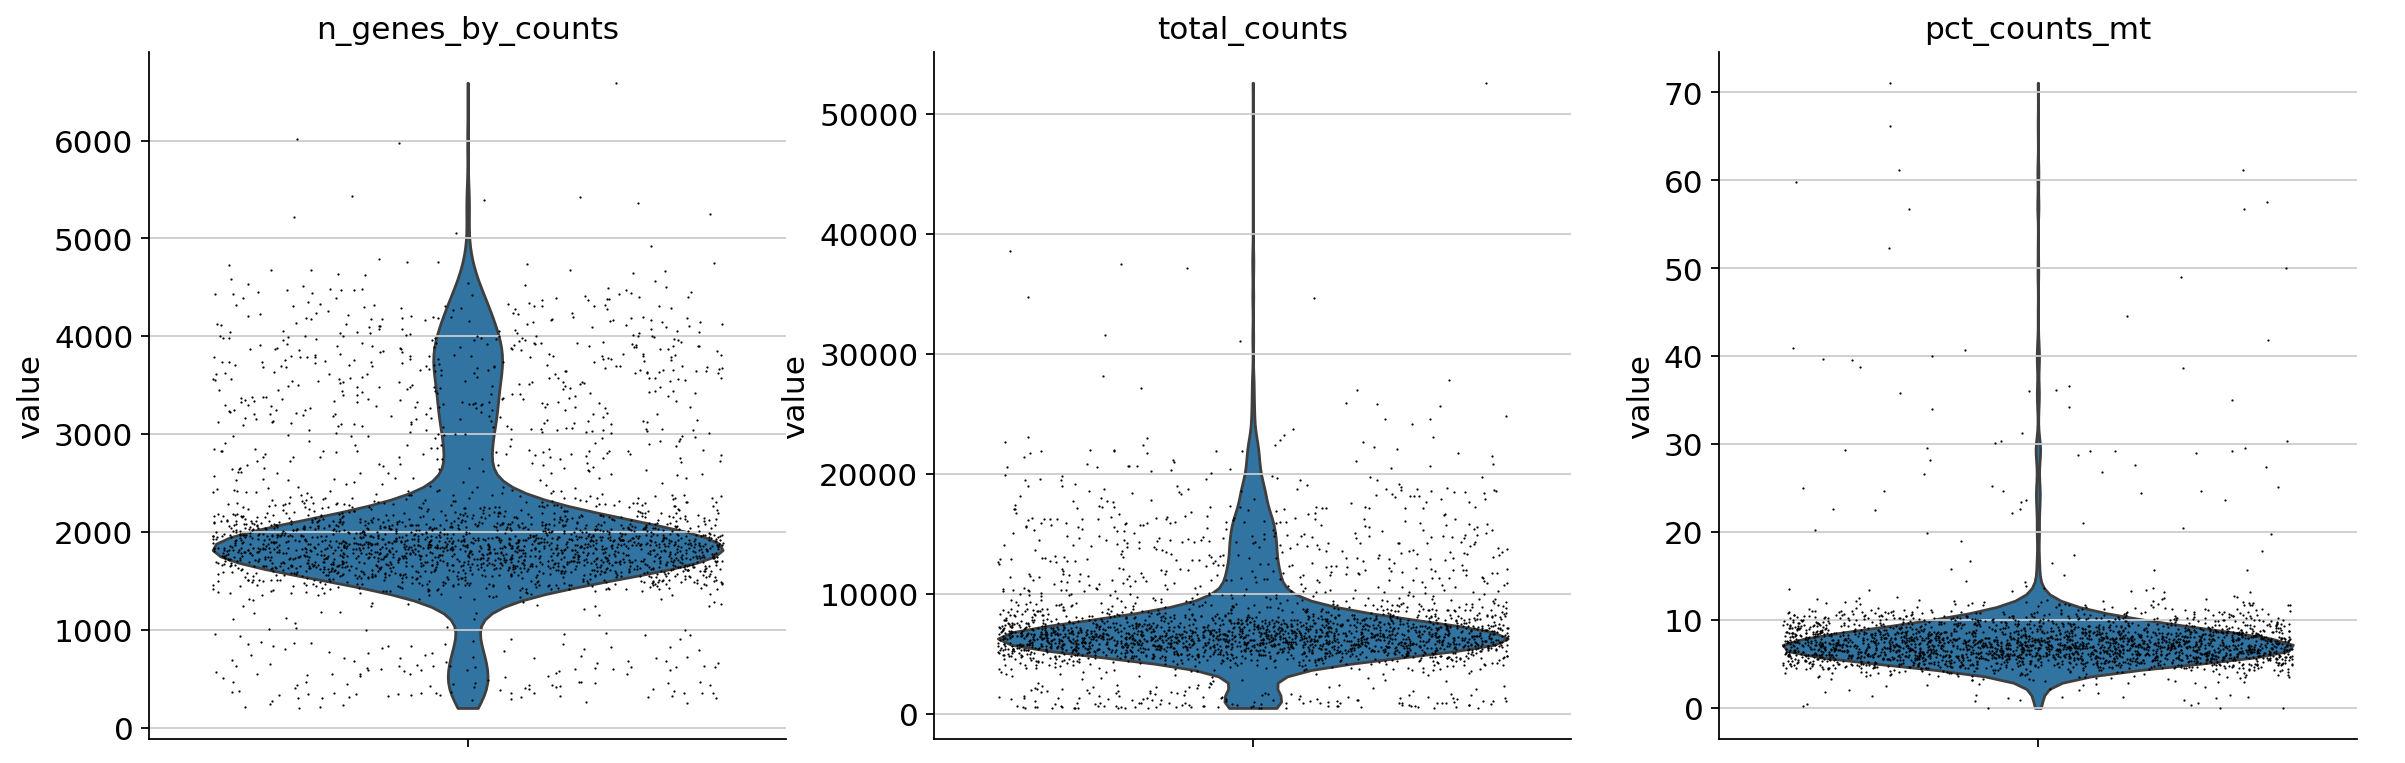

In [69]:
#A violin plot of some of the computed quality measures:
#the number of genes expressed in the count matrix
#the total counts per cell
#the percentage of counts in mitochondrial genes
sc.pl.violin(
    data,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],##图标题参照注释的含义
    jitter=0.4,
    multi_panel=True,
)

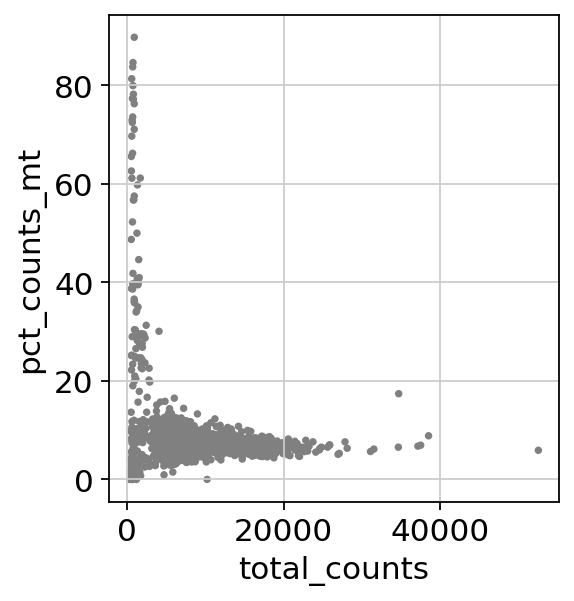

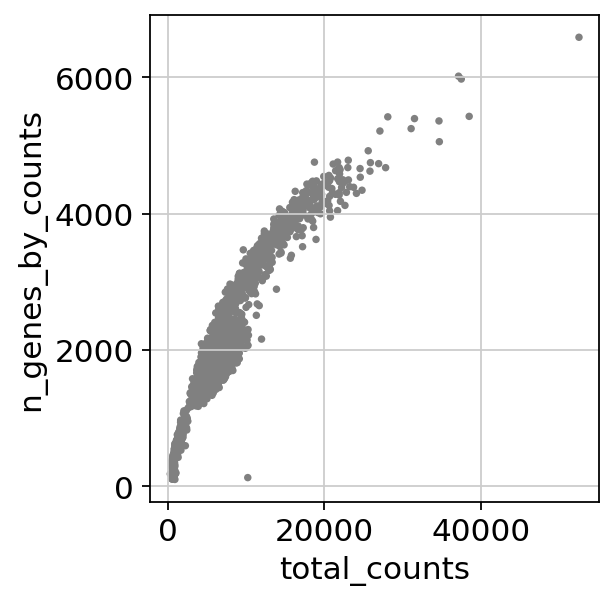

In [180]:
sc.pl.scatter(data, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(data, x="total_counts", y="n_genes_by_counts")
##删除线粒体基因表达过多或总计数过多的细胞

In [181]:
data = data[data.obs.n_genes < 5000, :]
data = data[data.obs.pct_counts_mt < 20, :]

In [183]:
sc.pp.normalize_total(data, target_sum=1e4) ##标准化

normalizing counts per cell
    finished (0:00:00)


In [184]:
sc.pp.log1p(data)#对数据进行对数运算

In [185]:
#Identify highly-variable genes.
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


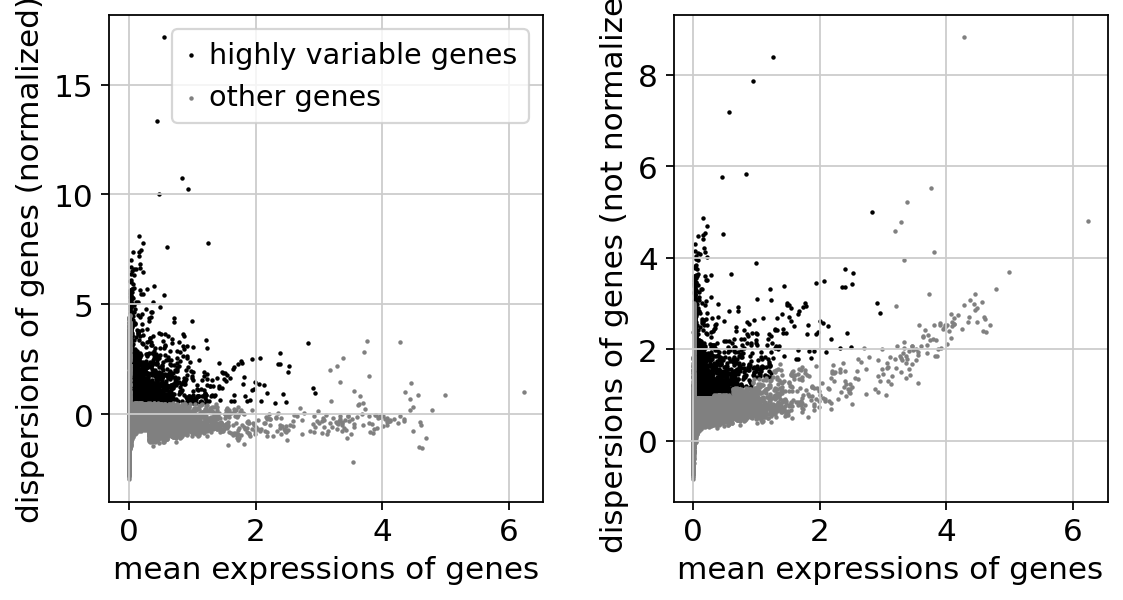

In [186]:
sc.pl.highly_variable_genes(data)

In [187]:
data.raw = data#保存数据，便于分析

In [188]:
data = data[:, data.var.highly_variable] 

In [189]:
sc.pp.regress_out(data, ["total_counts", "pct_counts_mt"])###对数据根据进行数量以及表达矫正

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/home/bioinfo2/PB22081501/miniconda3/envs/jupy/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:12)


In [190]:
sc.pp.scale(data, max_value=10)##将每个基因缩放为单位方差。剪切超过标准偏差 10 的值。

In [191]:
sc.tl.pca(data, svd_solver="arpack")####通过运行主成分分析（PCA）来降低数据维度，从而揭示变化的主轴并对数据进行去噪处理。

computing PCA
    with n_comps=50
    finished (0:00:03)


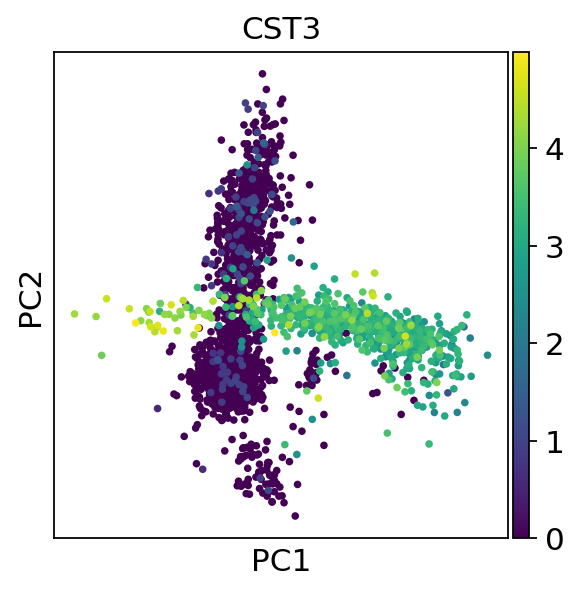

In [192]:
sc.pl.pca(data, color="CST3")###对PCA作图

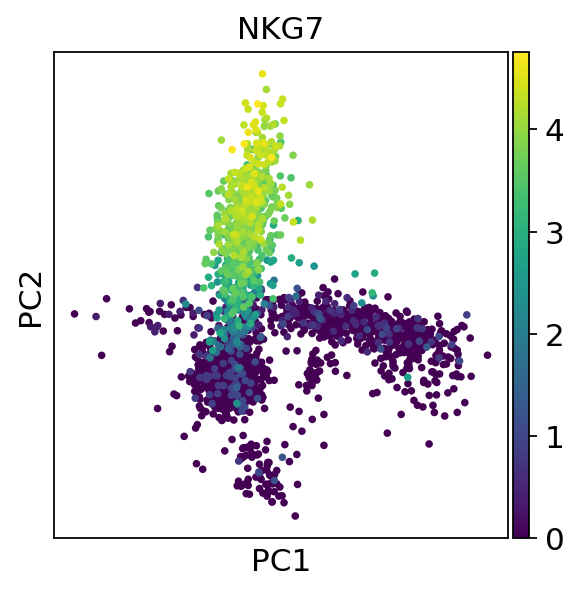

In [193]:
sc.pl.pca(data, color="NKG7")###对PCA作图

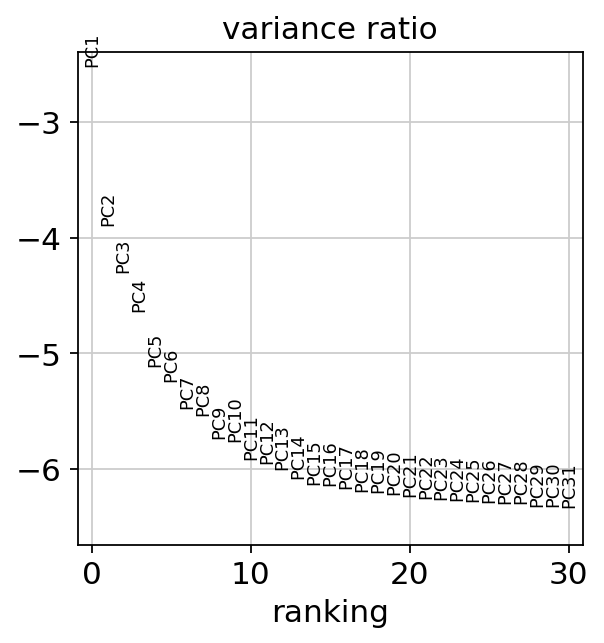

In [194]:
sc.pl.pca_variance_ratio(data, log=True)#为了计算单元的邻接关系，我们应该考虑多少个 PC，例
#如聚类函数 sc.tl.louvain() 或 tSNE sc.tl.tsne()。根据我们的经验，通常粗略估计 PC 的数量就可以了。

In [195]:
data.write(results_file)###保存数据

In [196]:
data

AnnData object with n_obs × n_vars = 2567 × 2492
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [197]:
sc.pp.neighbors(data, n_neighbors=10, n_pcs=40)####聚类分析开始

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [198]:
sc.tl.leiden(data) #使用leiden进行聚类，注意安装对应的python包，conda install -c conda-forge leidenalg ，当然也可使用其他的聚类算法，如louvain，sc.tl.louvain(data),sc.pl.umap(adata, color=['louvain'])，比较了一下，聚类结果差异不大

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [199]:
sc.tl.umap(data)#利用umap算法降维度

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


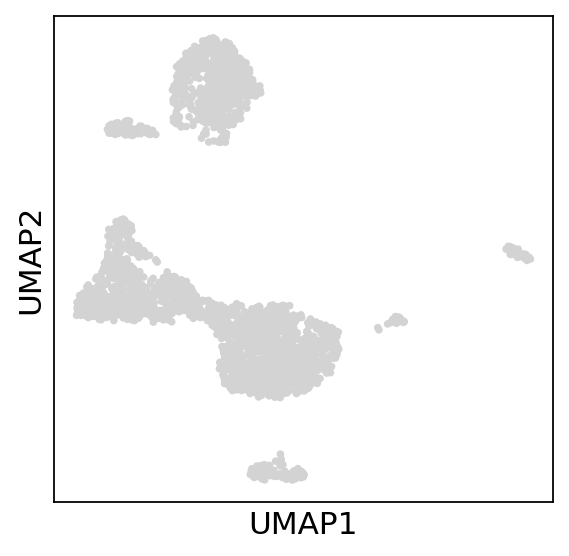

In [200]:
sc.pl.umap(data)#原始分群图

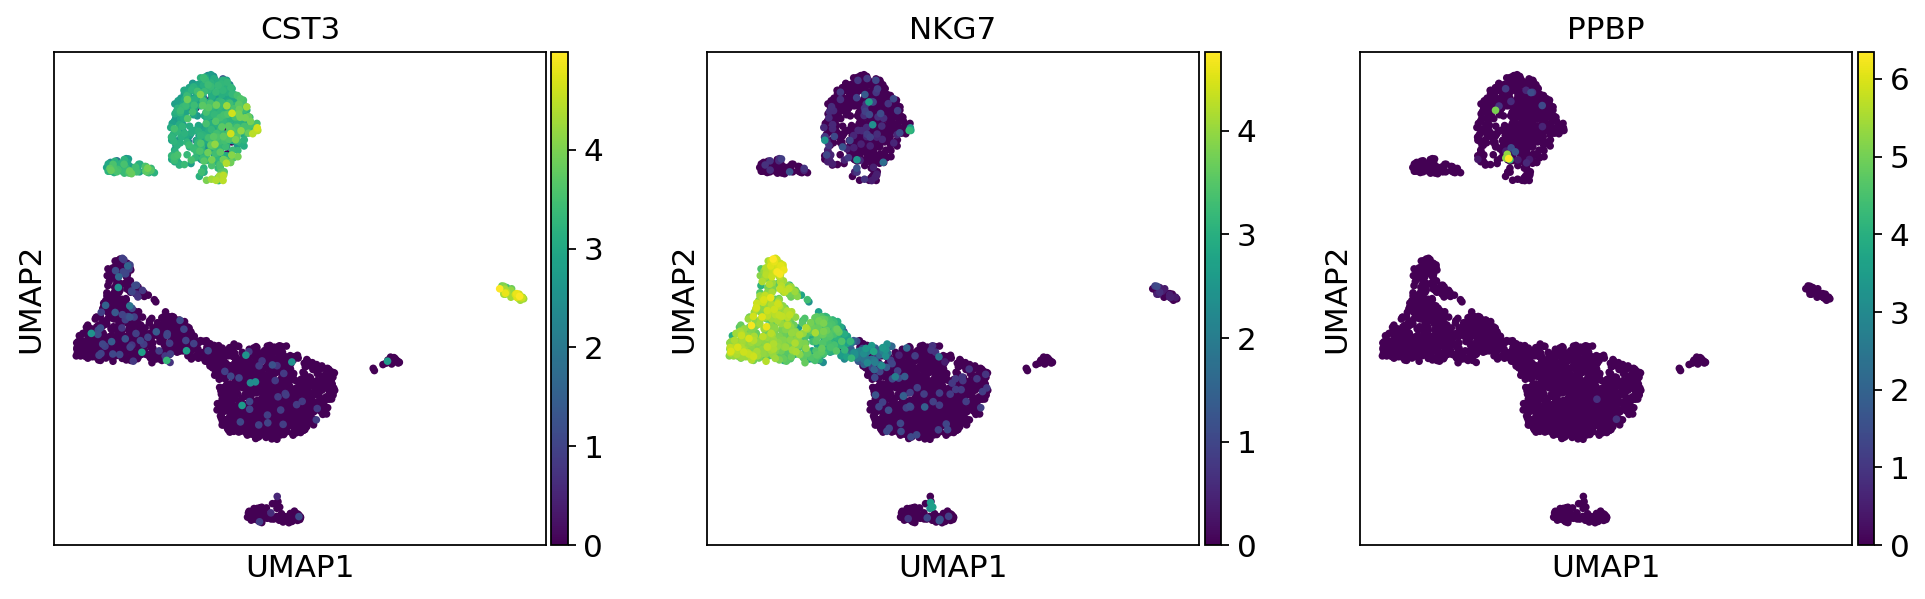

In [201]:
sc.pl.umap(data, color=["CST3", "NKG7", "PPBP"])

In [202]:
sc.tl.leiden(
    data,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


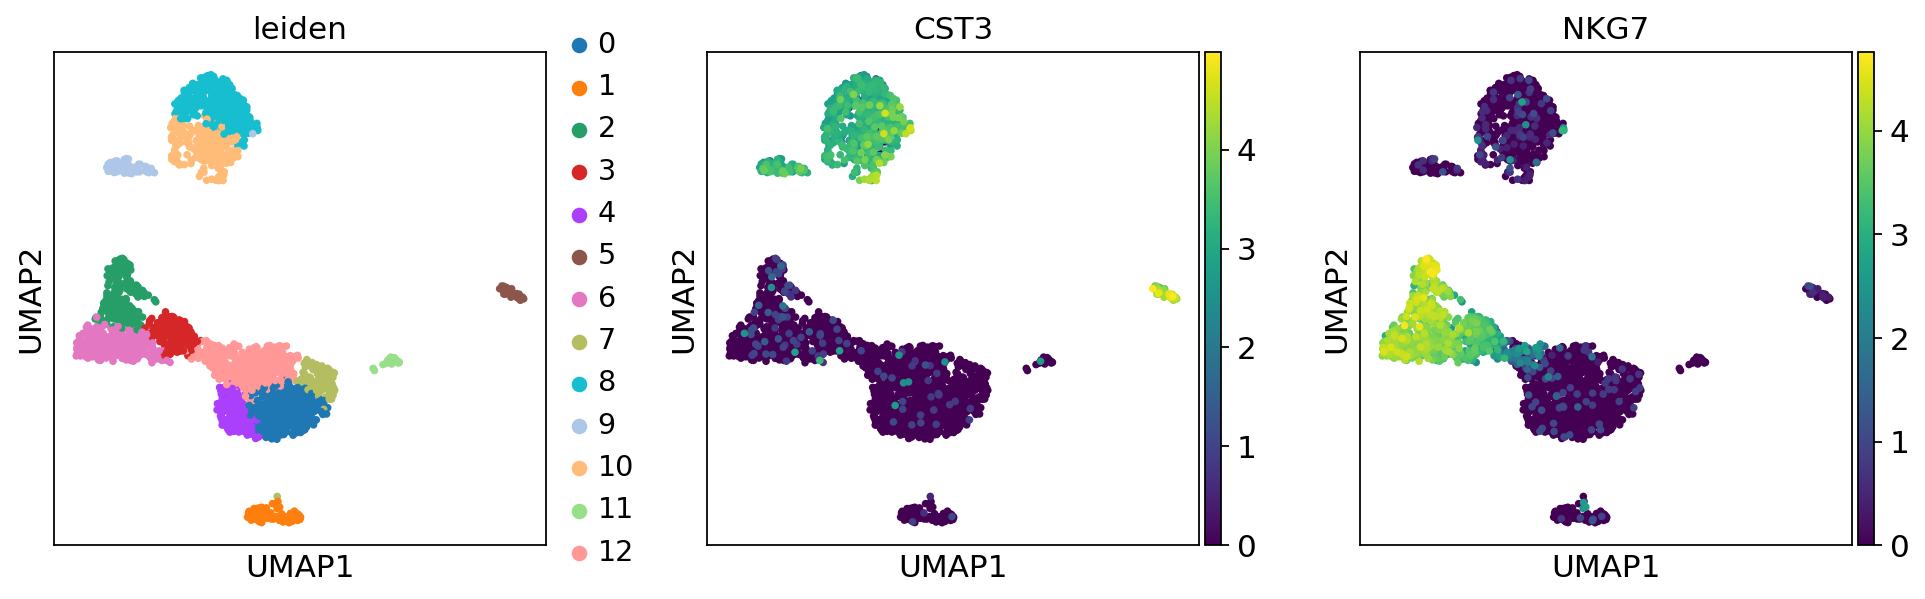

In [203]:
sc.pl.umap(data, color=["leiden", "CST3", "NKG7"])

In [204]:
data.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


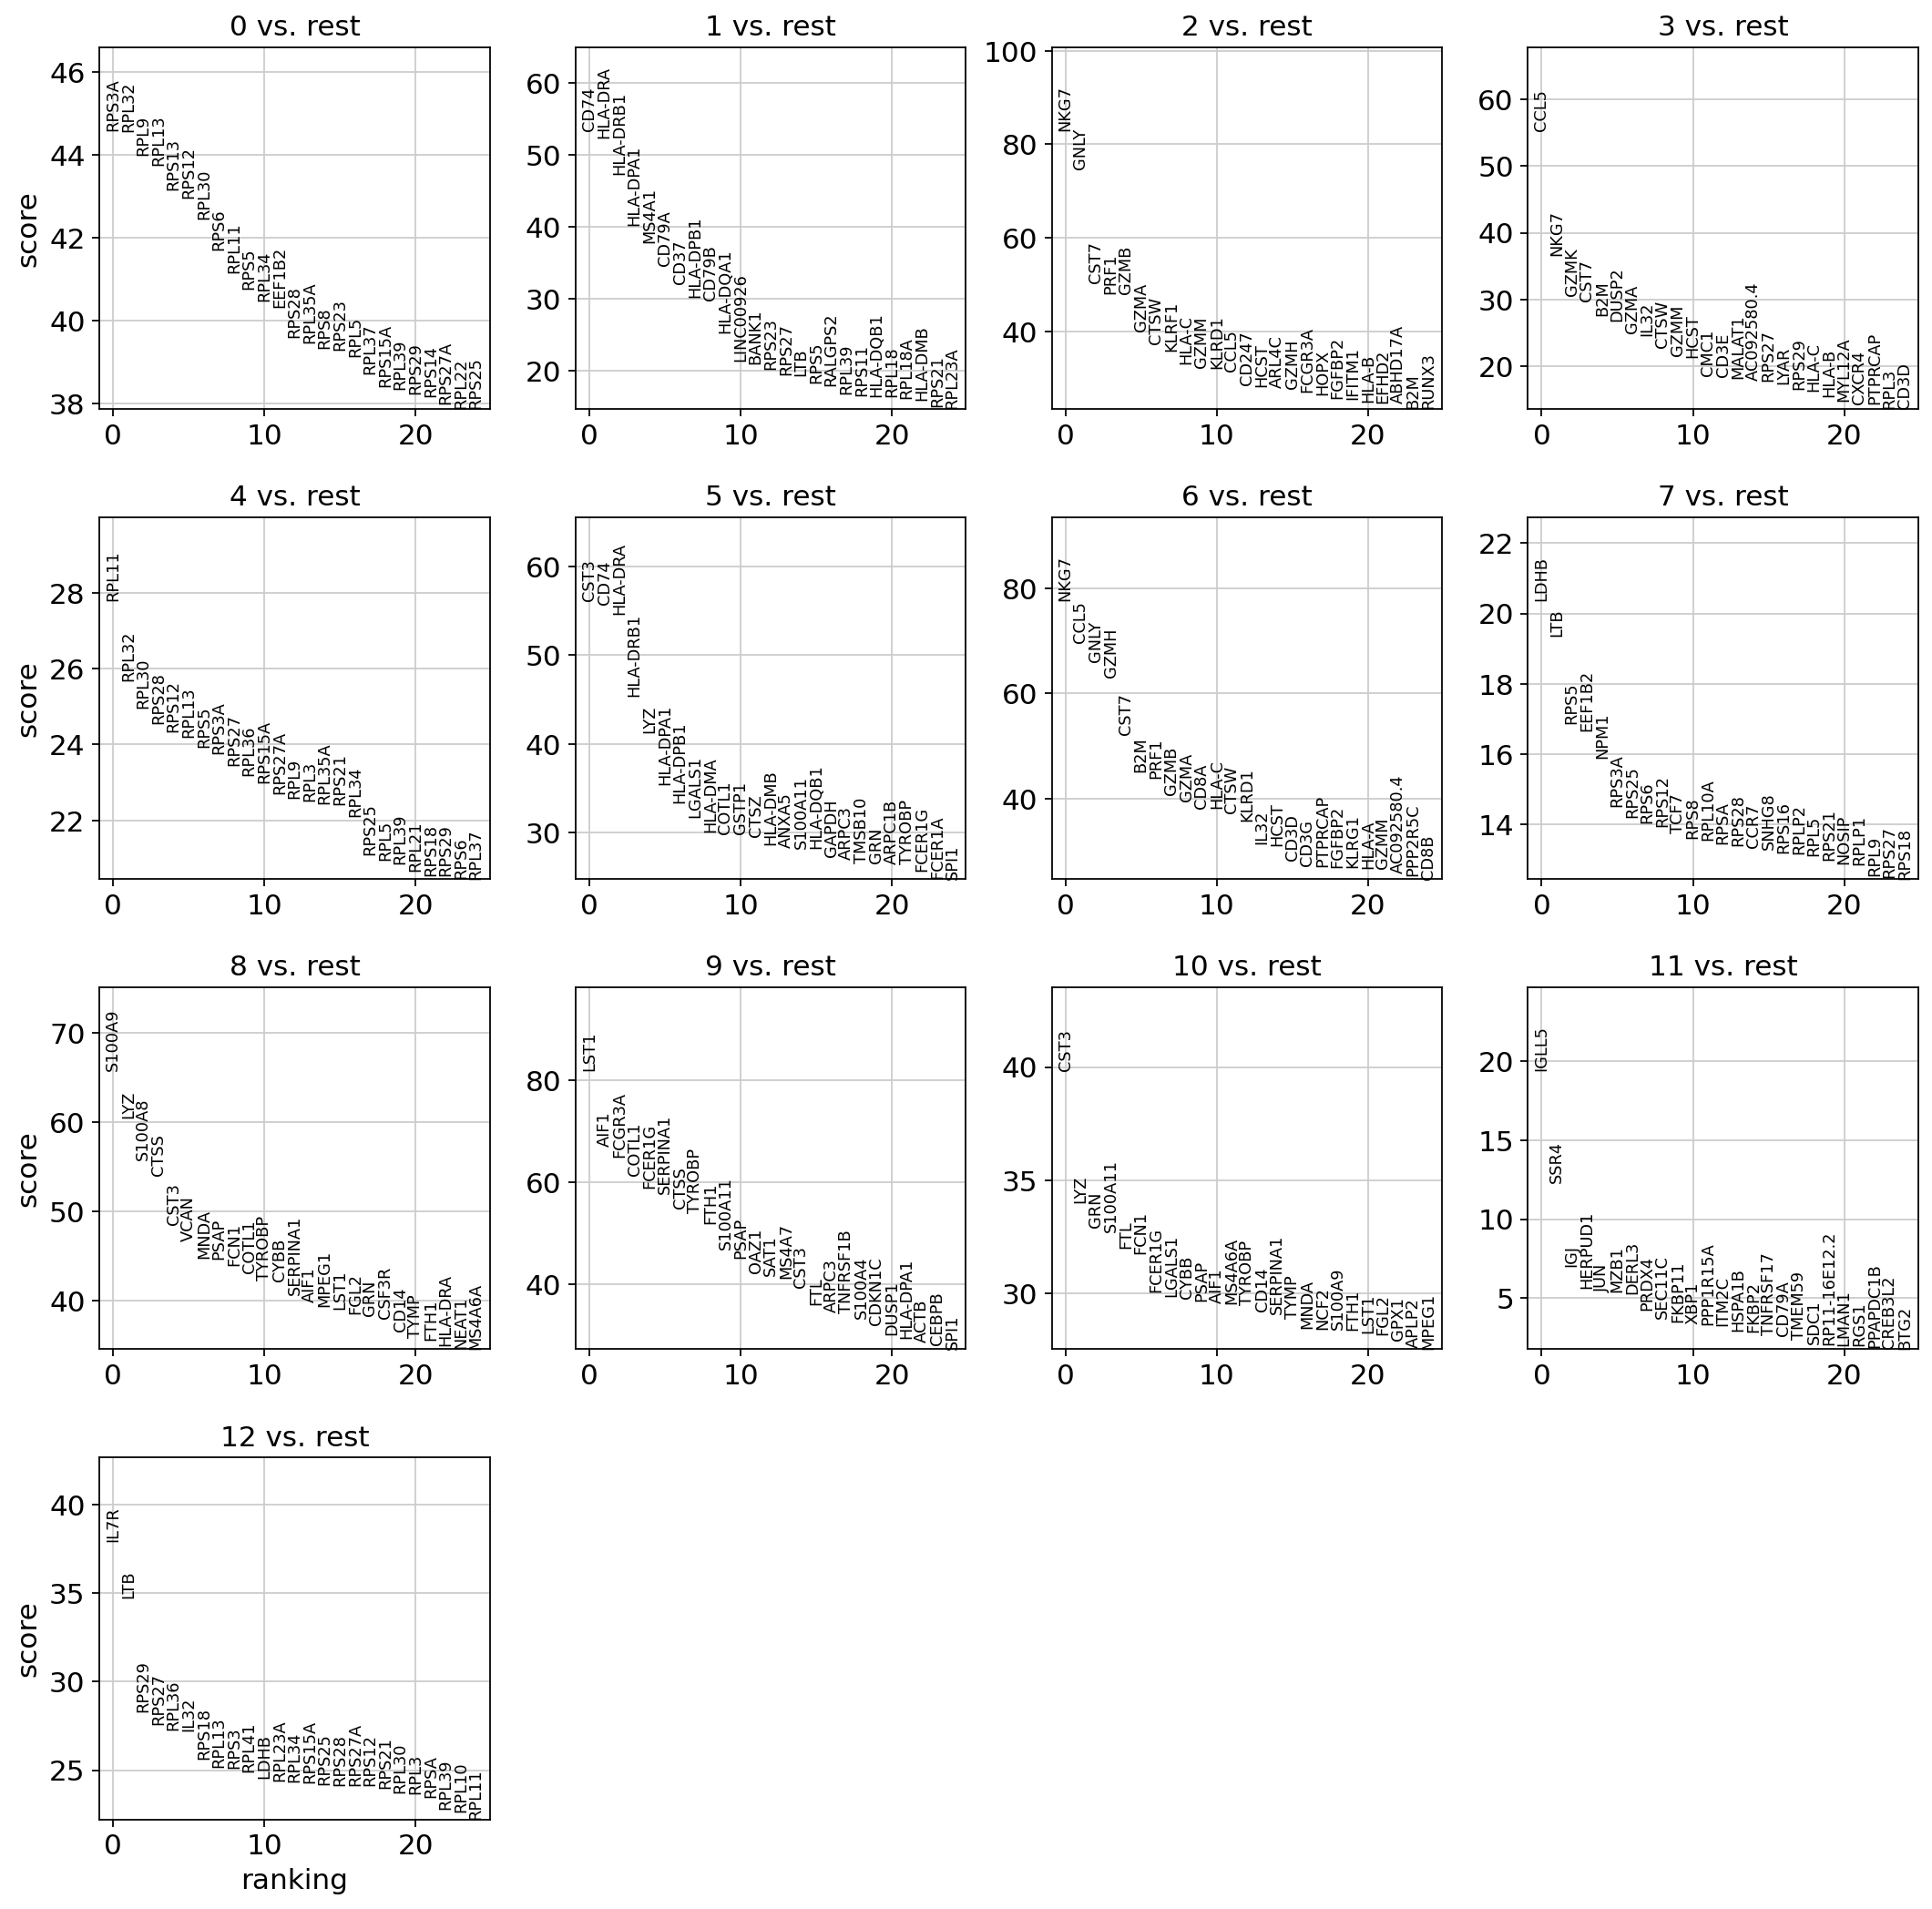

In [205]:
sc.tl.rank_genes_groups(data, "leiden", method="t-test")
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

/home/bioinfo2/PB22081501/miniconda3/envs/jupy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


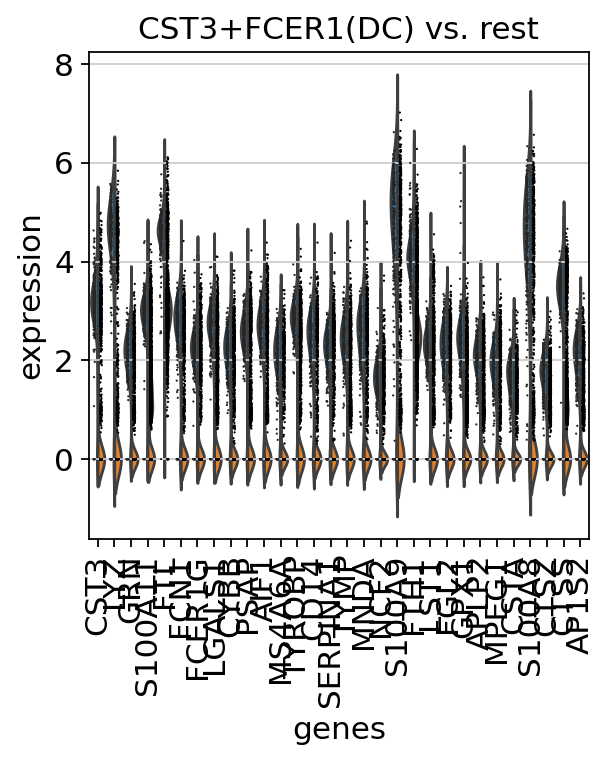

In [216]:
sc.pl.rank_genes_groups_violin(data, groups="CST3+FCER1(DC)", n_genes=30)

In [208]:
data.write(results_file)

In [209]:
data

AnnData object with n_obs × n_vars = 2567 × 2492
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

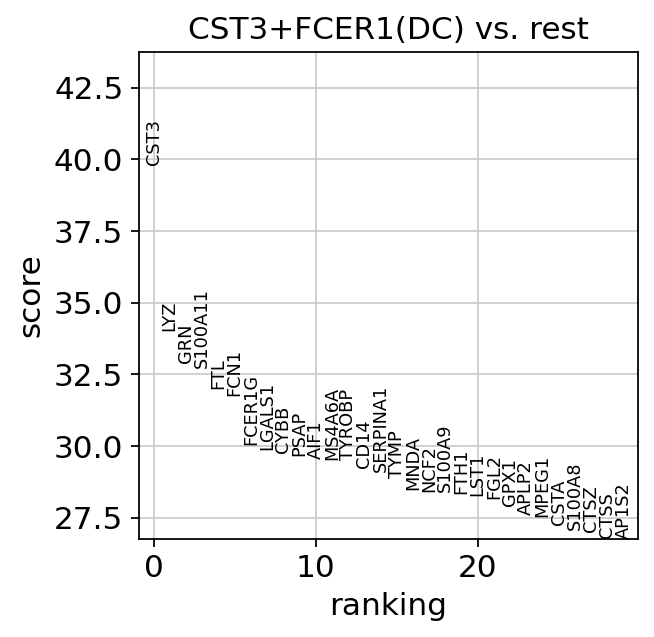

In [217]:
sc.pl.rank_genes_groups(data, groups=["CST3+FCER1(DC)"], n_genes=30)

In [218]:
pd.DataFrame(data.uns["rank_genes_groups"]["names"]).head(30)

,RPS3A,CD74,NKG7+GNLY,CCL5,RPL11,CST3+CD74,NKG7+CCL5,LDHB,S100A9,LST1,CST3+FCER1(DC),IGLL5,IL7R
0,RPS3A,CD74,NKG7,CCL5,RPL11,CST3,NKG7,LDHB,S100A9,LST1,CST3,IGLL5,IL7R
1,RPL32,HLA-DRA,GNLY,NKG7,RPL32,CD74,CCL5,LTB,LYZ,AIF1,LYZ,SSR4,LTB
2,RPL9,HLA-DRB1,CST7,GZMK,RPL30,HLA-DRA,GNLY,RPS5,S100A8,FCGR3A,GRN,IGJ,RPS29
3,RPL13,HLA-DPA1,PRF1,CST7,RPS28,HLA-DRB1,GZMH,EEF1B2,CTSS,COTL1,S100A11,HERPUD1,RPS27
4,RPS13,MS4A1,GZMB,B2M,RPS12,LYZ,CST7,NPM1,CST3,FCER1G,FTL,JUN,RPL36
5,RPS12,CD79A,GZMA,DUSP2,RPL13,HLA-DPA1,B2M,RPS3A,VCAN,SERPINA1,FCN1,MZB1,IL32
6,RPL30,CD37,CTSW,GZMA,RPS5,HLA-DPB1,PRF1,RPS25,MNDA,CTSS,FCER1G,DERL3,RPS18
7,RPS6,HLA-DPB1,KLRF1,IL32,RPS3A,LGALS1,GZMB,RPS6,PSAP,TYROBP,LGALS1,PRDX4,RPL13
8,RPL11,CD79B,HLA-C,CTSW,RPS27,HLA-DMA,GZMA,RPS12,FCN1,FTH1,CYBB,SEC11C,RPS3
9,RPS5,HLA-DQA1,GZMM,GZMM,RPL36,COTL1,CD8A,TCF7,COTL1,S100A11,PSAP,FKBP11,RPL41


In [212]:
new_cluster_names = [
    "RPS3A",
    "CD74",
    "NKG7+GNLY",
    "CCL5",
    "RPL11",
    "CST3+CD74",
    "NKG7+CCL5",
    "LDHB",
    "S100A9",
    "LST1",
    "CST3+FCER1(DC)",
    "IGLL5",
    "IL7R",
]
data.rename_categories("leiden", new_cluster_names)

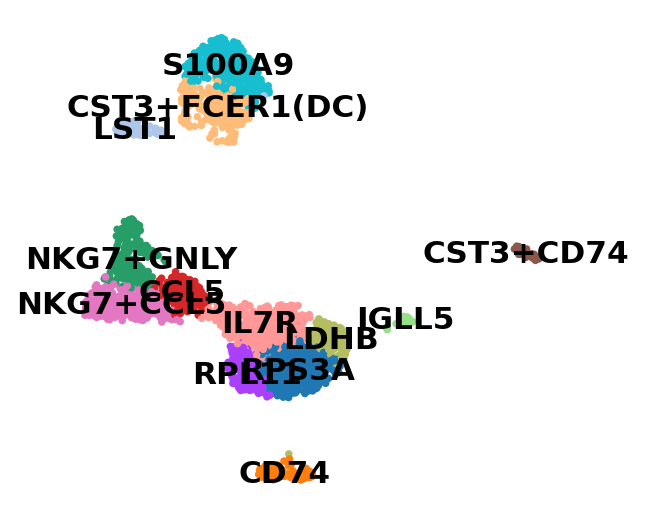

In [213]:
sc.pl.umap(
    data, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)